In [1]:
import os
import google.generativeai as genai

genai.configure(api_key='YOUR_API_KEY')

/home/regulus/Desktop/Python-envs/vlm-de-autonomous-driving/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import time
import io
import base64
from PIL import Image
from pynput.keyboard import Controller
import pyautogui
import numpy as np
import typing_extensions as typing
import os
import subprocess
import time
import json

def get_window_geometry(window_title):
    try:
        # `wmctrl`でウィンドウリストを取得
        wmctrl_output = subprocess.check_output(['wmctrl', '-l']).decode('utf-8')
        target_line = None

        for line in wmctrl_output.splitlines():
            if window_title in line:
                target_line = line
                break

        if not target_line:
            raise ValueError(f"Window with title '{window_title}' not found.")

        # ウィンドウIDを取得
        window_id = target_line.split()[0]
        
        # `xwininfo`でウィンドウの座標を取得
        xwininfo_output = subprocess.check_output(['xwininfo', '-id', window_id]).decode('utf-8')
        coords = {}
        for line in xwininfo_output.splitlines():
            if "Absolute upper-left X" in line:
                coords['x'] = int(line.split(':')[-1].strip())
            elif "Absolute upper-left Y" in line:
                coords['y'] = int(line.split(':')[-1].strip())
            elif "Width" in line:
                coords['width'] = int(line.split(':')[-1].strip())
            elif "Height" in line:
                coords['height'] = int(line.split(':')[-1].strip())

        if not coords:
            raise ValueError("Failed to get window coordinates.")

        return coords

    except Exception as e:
        raise RuntimeError(f"Failed to get window geometry: {e}")

def capture_window(window_title, output_path="screenshot.png", use_imagemagick=False):
    try:
        # ウィンドウの位置とサイズを取得
        geometry = get_window_geometry(window_title)

        if use_imagemagick:
            # ImageMagick (`import` コマンド) を使用してスクリーンショットを取得
            window_id = subprocess.check_output(
                ['wmctrl', '-l', '-x'], text=True
            ).splitlines()
            cmd = [
                'import', '-window', window_id,
                '-crop', f"{geometry['width']}x{geometry['height']}+{geometry['x']}+{geometry['y']}",
                output_path
            ]
            subprocess.run(cmd, check=True)
            return Image.open(output_path)
        else:
            # PyAutoGUIでスクリーンショットを取得
            screenshot = pyautogui.screenshot(region=(
                geometry['x'],
                geometry['y'],
                geometry['width'],
                geometry['height']
            ))
            screenshot.save(output_path)
            return screenshot

    except Exception as e:
        raise RuntimeError(f"Failed to capture window: {e}")

def preprocess_image(image):
    pil_image = image.copy()
    pil_image = pil_image.crop((0, pil_image.height // 2 - 200, pil_image.width, pil_image.height // 2 + 200))
    pil_image = pil_image.resize((pil_image.width // 4, pil_image.height // 4))
    display(pil_image)
    buffered = io.BytesIO()
    pil_image.save(buffered, format="PNG")
    image_str = base64.b64encode(buffered.getvalue()).decode()
    return pil_image, image_str

# Gemini APIへの送信とレスポンス取得
def send_to_gemini(img):
    prompt = f"""You will be given a forward image of the vehicle in motion, and based on this, you are to select the actions necessary to drive the racing kart on the track without hitting the walls. 
    Note that the walls are white and blue checks. The vehicle is currently going straight.
     - “↑”: continue straight ahead.
     - “←”: steer to the left
     - “→”: steer left
     """
    start = time.perf_counter() 
    response = model.generate_content(
        [prompt, img],
        generation_config=genai.GenerationConfig(
            response_mime_type="application/json",
            response_schema=ControlCommand
        ),
    )
    end = time.perf_counter()
    latency = end-start
    print(f"Latency: {latency}")
    return response, latency

# キーボード入力処理
def execute_action(action_response):
    action_response = json.loads(action_response.text.strip())
    command = action_response["command"]
    reason = action_response["reason"]
    print(f"Executing Command: {command}, Reason: {reason}")
    print()
    
    duration = 0.5  # 操舵の持続時間を秒単位で指定
    if command == "←":
        keyboard.press('a')
        time.sleep(duration)
        keyboard.release('a')
        keyboard.press('w')
    elif command == "→":
        keyboard.press('d')
        time.sleep(duration)
        keyboard.release('d')
        keyboard.press('w')
    elif command == "↑":
        keyboard.press('w')
    else:
        print("No valid command received or command is none.")

In [3]:
class ControlCommand(typing.TypedDict):
    command: str
    reason: str

# モデルの初期化
model = genai.GenerativeModel("gemini-1.5-flash")

# キーボードコントローラー
keyboard = Controller()

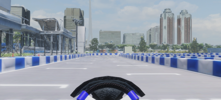

Latency: 1.5065057489991887
Executing Command: ↑, Reason: The road is straight ahead, and there is no need to steer.



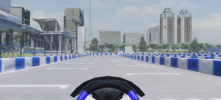

Latency: 1.1445687469968107
Executing Command: ↑, Reason: The road is straight ahead.



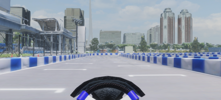

Latency: 1.1358699900010834
Executing Command: ↑, Reason: The road is straight ahead.



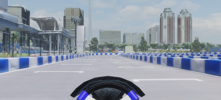

Latency: 1.2456085329904454
Executing Command: ↑, Reason: The road is straight ahead and there is no need to turn.



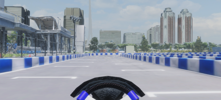

Latency: 1.1356858950020978
Executing Command: ↑, Reason: The road is straight ahead.



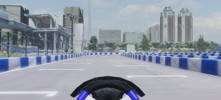

Latency: 1.1455196290044114
Executing Command: ↑, Reason: The road is straight ahead and there are no obstacles.



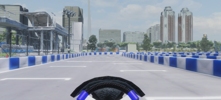

Latency: 1.2006890019983985
Executing Command: ↑, Reason: The road is straight ahead.



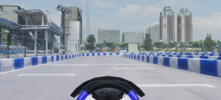

Latency: 1.1317621750058606
Executing Command: ↑, Reason: The road is straight ahead.



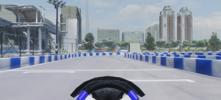

Latency: 1.224900961999083
Executing Command: ↑, Reason: The road is straight ahead, and there are no obstacles in the immediate view.



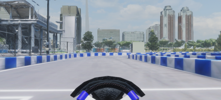

Latency: 1.122538618001272
Executing Command: ↑, Reason: The road is straight ahead.



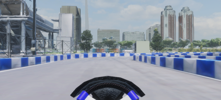

Latency: 1.1303526949923253
Executing Command: →, Reason: The track turns to the right in front of the vehicle.



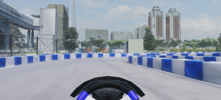

Latency: 1.0106799579953076
Executing Command: ↑, Reason: The road is straight ahead.



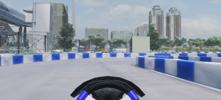

Latency: 1.1189253010088578
Executing Command: →, Reason: The track turns to the right.



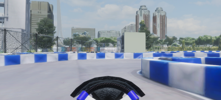

Latency: 1.1444159039965598
Executing Command: →, Reason: The kart needs to turn right to avoid hitting the wall.



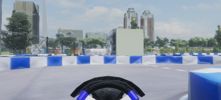

Latency: 1.1590019739960553
Executing Command: →, Reason: The track turns to the right.



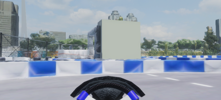

Latency: 1.0686582490016008
Executing Command: ↑, Reason: The road is clear ahead.



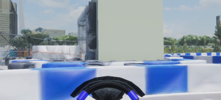

Latency: 1.1591467399994144
Executing Command: ←, Reason: The kart is about to hit the wall, therefore it needs to steer left to avoid collision.



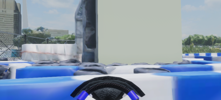

Latency: 1.2084302160074003
Executing Command: ←, Reason: The kart is approaching a wall on the right, therefore it needs to steer to the left to avoid collision.

Error in loop: Failed to capture window: Failed to get window geometry: Window with title 'AWSIM' not found.


In [4]:
while True:
    try:
        # 1. シミュレータの画面をキャプチャ
        frame = capture_window("AWSIM", use_imagemagick=False)
        
        # 2. キャプチャ画像を前処理して文字列化
        img, img_str = preprocess_image(frame)
        
        # 3. 画像をGeminiに送信して制御コマンドを取得
        action_response, latency = send_to_gemini(img)
        
        # 4. コマンドに基づきシミュレータを操作
        execute_action(action_response)
        
        # 15RPMに抑える
        if( 4.0 - latency > 0):
            time.sleep(4.0-latency)
        
    except Exception as e:
        print(f"Error in loop: {e}")
        break
